# Малютин Павел, ИТПЗ РАН
 

In [1]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [2]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/DOUBLE_PREC_DD (2).csv', sep = ';') 
my_cat = my_cat.loc[my_cat.latitude > 38.7751667]
my_cat = my_cat.loc[my_cat.latitude < 38.8081667]
my_cat = my_cat.loc[my_cat.longitude > -122.778]
my_cat = my_cat.loc[my_cat.longitude < -122.733]
my_cat = my_cat.reset_index(drop = True)
my_cat.mag = round(my_cat.mag, 1)  
my_cat

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,latitude,longitude,depth,EH1,EH2,AZ,EV,mag,ID
0,1984,1,5,22,28,2.400,38.78798,-122.77681,1.663,0.016,0.015,82,0.021,2.6,1109586
1,1984,1,5,23,9,52.920,38.78814,-122.77745,1.629,0.040,0.019,60,0.035,0.7,1109588
2,1984,1,7,14,24,9.790,38.78990,-122.77428,1.771,0.037,0.023,65,0.045,0.7,1109649
3,1984,1,8,2,7,38.960,38.78947,-122.77315,1.675,0.016,0.011,70,0.018,0.9,1109669
4,1984,1,9,2,12,4.417,38.78887,-122.77365,1.838,0.025,0.013,66,0.025,1.0,1109694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21656,2011,12,31,11,30,58.045,38.78704,-122.77651,2.087,0.016,0.010,51,0.015,0.9,71703390
21657,2011,12,31,15,34,9.080,38.77632,-122.74417,0.631,0.040,0.009,156,0.038,0.3,71703465
21658,2011,12,31,20,14,46.920,38.79161,-122.77501,4.139,0.036,0.020,53,0.037,0.5,71703620
21659,2011,12,31,20,54,49.431,38.79499,-122.74859,1.107,0.013,0.009,180,0.012,1.0,71703635


Text(0.5, 0.98, 'График повторяемости землетрясений')

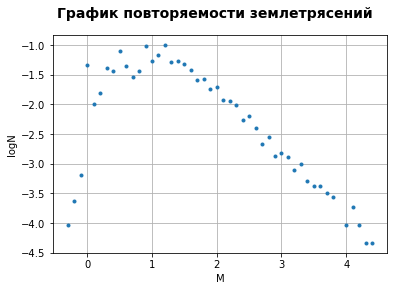

In [3]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [4]:
M_0 = float(input())
my_cat = my_cat.loc[my_cat['mag'] > M_0]
my_cat = my_cat.reset_index(drop = True)
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10))
# расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))
my_cat
N_tot = my_cat.shape

1.1
b-value is: 0.8549596900858577  ±  0.005809067030124341


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [5]:
global Pi2, RAD, FLAT
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть

In [6]:

def eq_dist (fi1, la1, fi2, la2, d1, d2): # fi - широта (latitude), la - долгота (longtitude)
    '''Функция позволяет вычислять расстояение между двумя точками земли с учетом сплюсности и глубины'''    
    #if ((fi1-fi2)==0 and (la1-la2)==0): #проверка на расстояние между одним и тем же землетрясением
    #    return (0.0)  
    col1 = Pi2 - math.atan(FLAT * math.tan(fi1 * RAD))
    col2 = Pi2 - math.atan(FLAT * math.tan(fi2 * RAD))
    
    dlon =  la2 * RAD - la1 * RAD
    
    cosdel = math.sin(col1) * math.sin (col2) * math.cos(dlon) + math.cos(col1) * math.cos(col2)
    delr = math.acos(cosdel)
    colat = Pi2 - (fi1 * RAD + fi2 * RAD) / 2.0
    distan_eq =  math.sqrt((delr * 6371.227 * (1.0 + 0.00337853 * (1./3. -((math.cos(colat))*math.cos(colat)))))**2 + (d2-d1)**2)
    if distan_eq == 0:
        distan_eq = 0.01
    return distan_eq

## Непосредственный расчёт фрактальной размерности

In [7]:
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = my_cat.latitude.to_numpy()
longitude = my_cat.longitude.to_numpy()
depth = my_cat.depth.to_numpy()

In [8]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''

array_of_dist = [[0] * N_tot[0] for i in range(N_tot[0])]

for i in tqdm(range((N_tot[0]))):
    for j in range(i+1, N_tot[0]):
        #array_of_dist.append(eq_dist(latitude[k], longitude[k], latitude[j], longitude[j], depth[k], depth[j]))
        array_of_dist[i][j] = eq_dist(latitude[i], longitude[i], latitude[j], longitude[j], depth[i], depth[j])
        array_of_dist[j][i] = array_of_dist[i][j]

100%|██████████████████████████████████████| 9560/9560 [06:52<00:00, 23.16it/s]


In [9]:
array_of_dist[2][:]

[0.44296099086213137,
 1.506568185851555,
 0,
 0.7251094347912873,
 1.2928785860250052,
 1.5001872105709584,
 0.4994320232126268,
 1.4259341232828782,
 1.4857027254391926,
 1.2202720055310583,
 1.2519364105870088,
 1.4888247388021303,
 1.592086756053326,
 1.2314539697024742,
 2.9783884384693917,
 1.04396065038743,
 1.143733963932687,
 1.2787805579581302,
 0.8512981185339175,
 0.9018861963344421,
 1.7755120071944592,
 1.1248424013757092,
 1.5118710585733761,
 1.4537170628301448,
 1.550692850726479,
 0.5376831225549838,
 0.7254544515439161,
 0.40301135466342425,
 0.9168977419780382,
 0.6848571536299061,
 0.3594067664079213,
 0.47787295673849645,
 0.35568111134562447,
 0.4035482391013653,
 0.33846921337153035,
 0.5639125324893718,
 1.5091769624785172,
 1.596811974553604,
 1.301624414818371,
 1.1762632466526868,
 1.3840699465446158,
 1.6080514812558904,
 1.3967812166246507,
 1.360954658956549,
 1.1687099615554364,
 0.3878151769317682,
 1.4161039127296284,
 1.5680322708981844,
 1.6650756159

In [ ]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.1,1,20) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):  
    for n in range(N_tot[0]):
        for m in range(n+1, N_tot[0]):
            if array_of_dist[n][m] < i:
                element_count += 1
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0
    #объединение старого массива для расчета FD и новых данных с lg(N/N_0) и lg(A)

 15%|██████▍                                    | 3/20 [00:44<04:15, 15.04s/it]

Text(0, 0.5, 'log(N/N_0)')

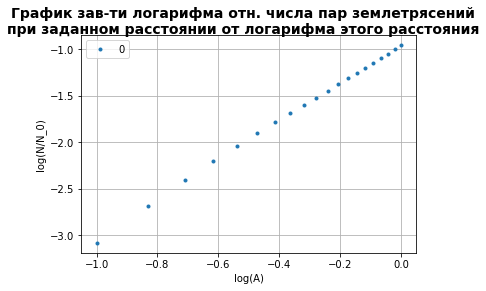

In [12]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

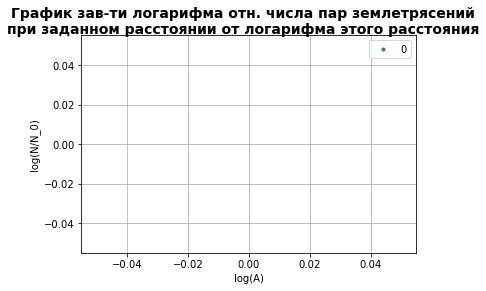

In [18]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model_d = LinearRegression()
linear_model_d.fit(X, Y)
d_f = linear_model_d.coef_[0][0] # фрактальная размерность
print('\033[1m' + 'Fractal dimension is', linear_model_d)

# Функция близости

In [ ]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

In [ ]:
n_ = [[0] * N_tot[0] for i in range(N_tot[0])]
T_ = [[0] * N_tot[0] for i in range(N_tot[0])]
my_cat.astype({'SECOND': 'int64'}).dtypes

In [ ]:
my_cat.SECOND = my_cat.SECOND.astype(int)
import datetime
year = my_cat.YEAR.to_numpy()
month = my_cat.MONTH.to_numpy()
day = my_cat.DAY.to_numpy()
hour = my_cat.HOUR.to_numpy()
minute = my_cat.MINUTE.to_numpy()
second = my_cat.SECOND.to_numpy()

### Функция для рассчёта времени между зт

In [ ]:
@jit 
def time_in_seconds (i, j):
    t_i = datetime.datetime(year[i], month[i], day[i], hour[i], minute[i], second[i])
    t_j = datetime.datetime(year[j], month[j], day[j], hour[j], minute[j], second[j])
    t_ij = (t_i - t_j).total_seconds()
    if t_ij == 0:
        return -0.1
    return -t_ij

In [ ]:
time_in_seconds(1,2)

In [ ]:
for i in tqdm(range(N_tot[0]-1,-1,-1)):
    for j in range(i,-1,-1):
        T_[i][j] = -time_in_seconds(i,j)
        T_[j][i] = T_[i][j]

In [ ]:
for i in tqdm(range(N_tot[0])):
    for j in range(i,N_tot[0]): #ВНИМАНИЕ - ХЗ ПОЧЕМУ ОТ И БЕРУ. ХОЧУ ПРОВЕРИТЬ
        if i == j:
            n_[i][j] = 10000000000
            n_[j][i] = 10000000000
            continue 
        n_[i][j] = T_[i][j]*(array_of_dist[i][j]**d_f)*(10**((-b_value)*my_cat.mag[i]))
        n_[j][i] = n_[i][j]

In [ ]:
n_[2][2]

In [ ]:
N = [0] * N_tot[0]
D = [0] * N_tot[0]
for i in range(len(n_)):
    D[i] = round(math.log10((min(n_[i][:]))),1)
    N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [ ]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist.csv')
Dist_to_Nearest.to_csv(filepath)

In [ ]:
Dist_to_Nearest